# Download Sentinel-2 Data using the EarthDaily Analytics EarthPlatform

This is a template notebook for downloading Sentinel-2 data from the EarthDaily Analytics EarthPlatform and creating tiled files that overlap with environmentally impacted mining sites that have been identified in Canada.

In [1]:
import os
import json
import requests
from pathlib import Path
from datetime import datetime

import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pystac_client import Client
from pystac.item import Item
from shapely.geometry import Polygon
from shapely.prepared import prep

from mine_seg_sat.download.stac import (
    get_sentinel2_data,
    remove_small_tiles,
    add_geometries_iteratively,
    download_files_for_item
)
from mine_seg_sat.utils.bands import get_band_specification
from mine_seg_sat.constants import EXTRACTED_BANDS
from mine_seg_sat.download.tile import generate_tiles


# Obtain mine shapefile from
mine_gdf = gpd.read_file('/Users/annabelle/Documents/NEU/CS7980/Capstone/shapefiles/thompson_nicola/thompson_nicola.shp')
mine_gdf = mine_gdf.to_crs("EPSG:4326")
start_date = "2023-08-10"
end_date = "2023-08-30"
print(f"Dropping {len(mine_gdf) - len(mine_gdf[mine_gdf.geometry.is_valid])} invalid geometries.")
mine_gdf = mine_gdf[mine_gdf.geometry.is_valid]
#mine_gdf has already been filtered to only contain valid geometries, the second
#mine_aoi = mine_gdf[mine_gdf.geometry.is_valid].unary_union
mine_aoi = mine_gdf.unary_union

len(mine_gdf)


Dropping 0 invalid geometries.


1

poetry add geopandas


In [2]:
import os
os.chdir('../')  # This moves you up one directory from 'notebooks' to 'your_project'



In [3]:
print(os.getcwd())


/Users/annabelle/Documents/NEU/CS7980/Capstone


In [4]:
import sys
sys.path.append(os.getcwd())  # since your current working directory is now 'your_project'


In [5]:
load_dotenv()

client_id = os.environ.get('CLIENT_ID')
client_secret = os.environ.get('CLIENT_SECRET')
auth_token_url = os.environ.get('AUTH_TOKEN_URL')
api_url = os.environ.get('API_URL')


def get_new_token():
    token_req_payload = {'grant_type': 'client_credentials'}
    token_response = requests.post(auth_token_url,
    data=token_req_payload, verify=False, allow_redirects=False,
    auth=(client_id, client_secret))
    token_response.raise_for_status()

    tokens = json.loads(token_response.text)
    return tokens['access_token']


token = get_new_token()
client = Client.open(api_url, headers={ "Authorization": f"Bearer {token}" })


/Users/annabelle/Documents/NEU/CS7980/Capstone/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'uvic-earthdaily.auth.us-east-1.amazoncognito.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/var/folders/qp/39q3q5193vb9k27hwzyk9fk80000gn/T/ipykernel_32499/2904796376.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


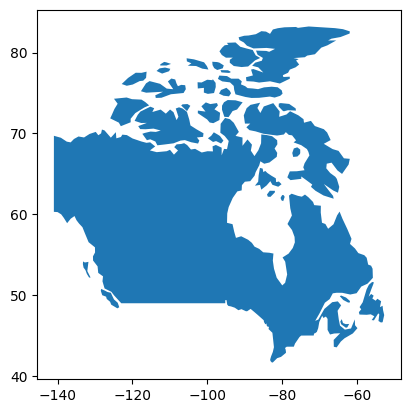

In [6]:
def load_canada_map() -> gpd.GeoDataFrame:
    # CRS is EPSG:4326
    gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    return gdf[gdf.name == "Canada"]

areas_geojson = load_canada_map()
areas_geojson.iloc[0].geometry
#better visulization
areas_geojson.plot()
plt.show()


In [7]:
def grid_bounds(geom, delta):
    # Convert a larger shapefile into grids...
    # Logic retrieved from:
    # https://www.matecdev.com/posts/shapely-polygon-gridding.html
    minx, miny, maxx, maxy = geom.bounds
    nx = int((maxx - minx)/delta)
    ny = int((maxy - miny)/delta)
    gx, gy = np.linspace(minx,maxx,nx), np.linspace(miny,maxy,ny)
    grid = []
    for i in range(len(gx)-1):
        for j in range(len(gy)-1):
            poly_ij = Polygon([[gx[i],gy[j]],[gx[i],gy[j+1]],[gx[i+1],gy[j+1]],[gx[i+1],gy[j]]])
            grid.append(poly_ij)

    return grid



def partition(geom, delta):
    prepared_geom = prep(geom)
    grid = list(filter(prepared_geom.intersects, grid_bounds(geom, delta)))
    return grid


polygons = partition(areas_geojson.iloc[0].geometry, 5)


In [8]:
def get_intersecting_polygons(polygons, mine_aoi):
    """
    Given an area with larger multipolygons, and a group of polygons return a list of
    polygons that intersect with the area of interest.
    """
    intersecting_polygons = []
    for polygon in polygons:
        if mine_aoi.intersects(polygon):
            intersecting_polygons.append(polygon)
    return intersecting_polygons

wanted_polygons = get_intersecting_polygons(polygons, mine_aoi)
len(polygons), len(wanted_polygons)


(91, 2)

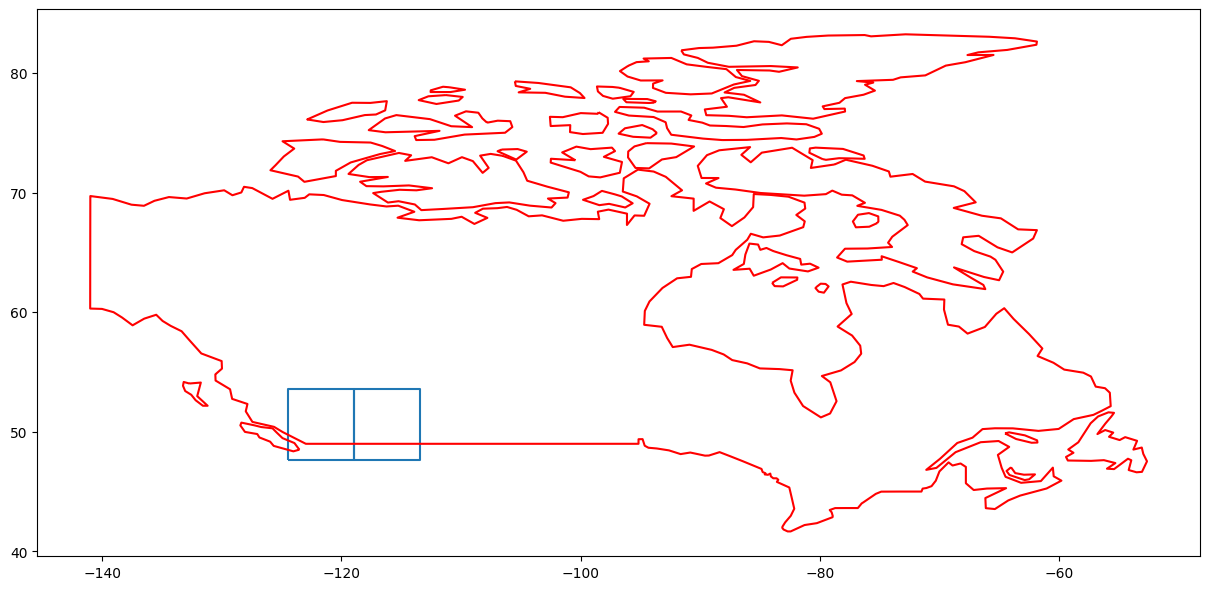

In [9]:
# show tiles that intersect with an identified environmentally impacted mining area
fig, ax = plt.subplots(figsize=(15, 15))
gpd.GeoSeries(wanted_polygons).boundary.plot(ax=ax)
gpd.GeoSeries([areas_geojson.iloc[0].geometry]).boundary.plot(ax=ax, color="red")
plt.show()


In [10]:
###########
###new#####
###########
from concurrent.futures import ThreadPoolExecutor

def process_polygon(polygon):
    poly_obj = {
        "type": "Polygon",
        "coordinates": list(polygon.__geo_interface__["coordinates"])
    }
    items, tile_gdf = get_sentinel2_data(client, poly_obj, start_date, end_date)
    if len(items) == 0:
        print("No items found for given area... Not great.")
        return None, None

    tile_gdf = remove_small_tiles(tile_gdf, reproject=True)
    _, tile_gdf = add_geometries_iteratively(tile_gdf)

    wanted_gdf = tile_gdf[tile_gdf.intersects(mine_aoi)]
    wanted_tiles = [name.split("/")[-1] for name in wanted_gdf["earthsearch:s3_path"].tolist()]
    wanted_items = [item for item in items if item.id in wanted_tiles]

    return wanted_items, wanted_gdf

def get_all_overlapping_tiles(polygons, start_date, end_date):
    print(f"Getting area for: {len(polygons)} polygons")

    all_items = []
    all_gdfs = []

    with ThreadPoolExecutor() as executor:
        results = list(executor.map(process_polygon, polygons))

    for items, gdf in results:
        if items is not None:
            all_items.append(items)
        if gdf is not None:
            all_gdfs.append(gdf)

    return all_items, all_gdfs

all_items, all_gdfs = get_all_overlapping_tiles(wanted_polygons, start_date, end_date)


Getting area for: 2 polygons
Found: 168 tiles.
Found: 118 tiles.


In [11]:
def get_all_overlapping_tiles(polygons, start_date, end_date):
    print(f"Getting area for: {len(polygons)} polygons")
    all_items, all_gdfs = [], []
    for polygon in polygons:
        poly_obj = {
            "type": "Polygon",
            "coordinates": list(polygon.__geo_interface__["coordinates"])
        }
        items, tile_gdf = get_sentinel2_data(client, poly_obj, start_date, end_date)
        if len(items) == 0:
            print("No items found for given area... Not great.")
            continue

        tile_gdf = remove_small_tiles(tile_gdf, reproject=True)
        _, tile_gdf = add_geometries_iteratively(tile_gdf)

        wanted_gdf = tile_gdf[tile_gdf.intersects(mine_aoi)]
        wanted_tiles = [name.split("/")[-1] for name in wanted_gdf["earthsearch:s3_path"].tolist()]
        wanted_items = [item for item in items if item.id in wanted_tiles]
        all_items.append(wanted_items)
        all_gdfs.append(wanted_gdf)

    return all_items, all_gdfs


all_items, all_gdfs = get_all_overlapping_tiles(wanted_polygons, start_date, end_date)


Getting area for: 2 polygons
Found: 118 tiles.
Found: 168 tiles.


In [12]:
items = [item for sublist in all_items for item in sublist] # covers western canada
gdfs = pd.concat(all_gdfs)
len(items), len(gdfs)


(22, 22)

In [13]:
mine_map = mine_gdf.explore(color="red")
gdfs.explore(m=mine_map)


In [14]:
high_resolution_bands = {"red": "B04", "green": "B03", "blue": "B02", "nir": "B08"}
mid_resolution_bands = {"rededge1": "B05", "rededge2": "B06", "rededge3": "B07", "nir08": "B8A", "swir16": "B11", "swir22": "B12"}
low_resolution_bands = {"coastal": "B01", "nir09": "B09"}

other_files = {
    "scl": "scl", # Scene Classification Map
    "aot": "aot", # Aerosol Optical Thickness
    "tileinfo_metadata": "metadata" # Tile Metadata
}

all_download_files = {**high_resolution_bands, **mid_resolution_bands, **low_resolution_bands, **other_files}


In [15]:
from concurrent.futures import ThreadPoolExecutor

def process_tile(tile, output_dir, all_download_files, aoi_gdf):
    downloaded_ids = []

    try:
        dt_obj = datetime.strptime(tile.properties["datetime"], "%Y-%m-%dT%H:%M:%S.%fZ")
        formatted_date = dt_obj.strftime('%Y%m%d')
        out_path = output_dir / tile.id / formatted_date
        downloaded = download_files_for_item(tile, all_download_files, out_path)

        if downloaded:
            downloaded_ids.append(tile.properties["s2:granule_id"])
            for file in out_path.iterdir():
                band_name, window_size = get_band_specification(file)
                if band_name and window_size:
                    out_dir = file.parent / "tiles"
                    if not out_dir.exists():
                        out_dir.mkdir(parents=True)
                    generate_tiles(file, out_dir, band_name, window_size, aoi_gdf)
    except Exception as e:
        print(f"Error processing tile {tile.id}: {e}")

    return downloaded_ids

def download_and_tile_files(gdf: gpd.GeoDataFrame, items: list[Item], aoi_gdf: gpd.GeoDataFrame, output_dir: Path):
    gdf["downloaded"] = False

    with ThreadPoolExecutor(max_workers=5) as executor:  # Adjust max_workers based on your system's capacity
        all_downloaded_ids = list(executor.map(lambda tile: process_tile(tile, output_dir, all_download_files, aoi_gdf), items))

    for downloaded_ids in all_downloaded_ids:
        for id in downloaded_ids:
            gdf.loc[gdf["s2:granule_id"] == id, "downloaded"] = True

    print(f"Downloaded: {len(gdf[gdf['downloaded'] == True])} / {len(gdf)} files. {len(gdf[gdf['downloaded'] == False])} failed to download.")

output_dir = Path("/Users/annabelle/Documents/NEU/CS7980/Capstone/download_file2")
download_and_tile_files(gdfs, items, mine_gdf, output_dir)


Processed tiles: 155, blank tiles: 0, misshapen tiles: 29, no_mask: 41
Processed tiles: 155, blank tiles: 0, misshapen tiles: 29, no_mask: 41
Processed tiles: 155, blank tiles: 0, misshapen tiles: 29, no_mask: 41
Processed tiles: 155, blank tiles: 0, misshapen tiles: 29, no_mask: 41
Processed tiles: 155, blank tiles: 0, misshapen tiles: 29, no_mask: 41
Processed tiles: 155, blank tiles: 0, misshapen tiles: 29, no_mask: 41
Processed tiles: 155, blank tiles: 0, misshapen tiles: 29, no_mask: 41
Processed tiles: 155, blank tiles: 0, misshapen tiles: 29, no_mask: 41
Processed tiles: 155, blank tiles: 0, misshapen tiles: 29, no_mask: 41
Processed tiles: 155, blank tiles: 0, misshapen tiles: 29, no_mask: 41
Processed tiles: 155, blank tiles: 0, misshapen tiles: 29, no_mask: 41
Processed tiles: 155, blank tiles: 0, misshapen tiles: 29, no_mask: 41
Processed tiles: 64, blank tiles: 0, misshapen tiles: 29, no_mask: 132


/Users/annabelle/Documents/NEU/CS7980/Capstone/venv/lib/python3.9/site-packages/rasterio/features.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _rasterize(valid_shapes, out, transform, all_touched, merge_alg)


Processed tiles: 64, blank tiles: 0, misshapen tiles: 29, no_mask: 132
Processed tiles: 29, blank tiles: 0, misshapen tiles: 29, no_mask: 167
Processed tiles: 64, blank tiles: 0, misshapen tiles: 29, no_mask: 132
Processed tiles: 29, blank tiles: 0, misshapen tiles: 29, no_mask: 167
Processed tiles: 29, blank tiles: 0, misshapen tiles: 29, no_mask: 167
Processed tiles: 75, blank tiles: 0, misshapen tiles: 29, no_mask: 121
Processed tiles: 64, blank tiles: 0, misshapen tiles: 29, no_mask: 132
Processed tiles: 75, blank tiles: 0, misshapen tiles: 29, no_mask: 121
Processed tiles: 75, blank tiles: 0, misshapen tiles: 29, no_mask: 121
Processed tiles: 29, blank tiles: 0, misshapen tiles: 29, no_mask: 167
Processed tiles: 64, blank tiles: 0, misshapen tiles: 29, no_mask: 132
Processed tiles: 64, blank tiles: 0, misshapen tiles: 29, no_mask: 132
Processed tiles: 75, blank tiles: 0, misshapen tiles: 29, no_mask: 121
Processed tiles: 29, blank tiles: 0, misshapen tiles: 29, no_mask: 167
Proces